In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdp_tut_functions as mdp43wa
import env_functions as ef
from rl_utils import running_mean, discount_rwds

# set seed for pseudorandom number generation -- make sure our trajectories look the same
np.random.seed(80)

%matplotlib inline

from importlib import reload

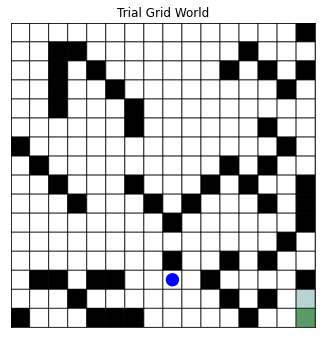

In [2]:
n_rows,n_cols = 16,16
step_penalization=-0.01
gw_obst = ef.GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(4,2),(3,2),(2,2),(1,2),(1,3),(2,4),(3,5),(4,6),(5,6),(7,11),(8,10),(15,12),(9,9),(7,13),(10,8),(9,9),(9,7),(8,6),(13,1),(13,2),(12,8),(8,12),(9,13),(14,3),(12,11),(15,4),(13,15),(14,13),(13,10),(15,5),(15,4),(13,4),(13,5),(5,13),(6,14),(9,15),(10,15),(11,14),(12,13),(14,11),(12,11),(6,0),(7,1),(8,2),(9,3),(15,6),(8,15),(15,0),(0,15),(2,11),(1,12),(2,13),(3,14),(2,15),(13,4)], 
                  rewards={(15,15):10},
                  terminals=[(14,15)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=False
                 )

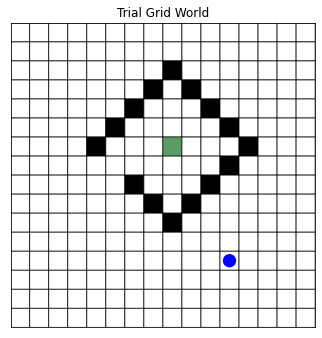

In [3]:
n_rows,n_cols = 16,16
step_penalization=-0.01
gw_obst = ef.GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(6,4),(5,5),(4,6),(3,7),(2,8),(3,9),(4,10),(5,11),(6,12),(7,11),(8,10),(9,9),(10,8),(9,9),(9,7),(8,6)], 
                  rewards={(6,8):10},
                  terminals=[(6,8)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=False
                 )


In [4]:
class Q_Agent(object):
    def __init__(self, nstates, nactions, 
                 learning_rate=0.1, discount=0.9, epsilon=1): 
        
        self.num_actions = nactions
        self.num_states = nstates
        self.action_space = np.arange(self.num_actions)

        # this agent selects actions from a table of state,action values which we initalize randomly
        #self.q_table = np.random.uniform(low=-1, high=1, size=(nstates, nactions))
        self.q_table = np.zeros((gw_obst.nstates, gw_obst.nactions))

        # parameters for learning
        self.epsilon       = epsilon
        self.learning_rate = learning_rate
        self.discount      = discount # gamma
        
    def choose_action(self, state):
        # this agent uses epsilon-greedy action selection, meaning that it selects 
        # the greedy (highest value) action most of the time, but with epsilon probability
        # it will select a random action -- this helps encourage the agent to explore
        # unseen trajectories
        
        ## TO DO -- write action selection for an epsilon-greedy policy 
        if np.random.random()>self.epsilon:
            # take the action which corresponds to the highest value in the q table at that row (state)
            action = np.argmax(self.q_table[state])
        else:
            action = np.random.choice(self.action_space)
        return action
    
    def update_q_table(self, current_state, current_action, reward, new_state):
        # this function describes how the Q table gets updated so the agent can make 
        # better choices based on what it has experienced from the environment 
        current_q = self.q_table[ current_state, current_action]
        max_future_q = np.max(self.q_table[new_state,:])
        
        ## TO DO -- write the Q value update using Q-learning
        new_q = current_q + self.learning_rate*(reward+self.discount*max_future_q-current_q)
        self.q_table[current_state, current_action] = new_q
        
    def navigate(self, gw_obst, num_episodes, random_start=False, start=0):
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)
        snapshot=[]

        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking=[]
        max_steps= 1000

        for episode in range(num_episodes):
            gw_obst.reset()
            # initalize reward counter
            total_reward=0

            # get first state
            if random_start:
                state=gw.obst.state
            else:
                state=start

            for step in range(max_steps):
                action = self.choose_action(state)
                # take a step in the environment
                next_state, reward, done, _ = gw_obst.step(action)

                total_reward+=reward

                if not done:
                    self.update_q_table(state, action, reward, next_state)
                else:
                    self.q_table[state, action] = 0
                    break
                state=next_state

            reward_tracking.append(total_reward)
            snapshot.append(self.q_table.copy())



            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking,snapshot
    

In [5]:
class Dyna_Q_Agent(object):
    def __init__(self, nstates, nactions, 
                 learning_rate=0.1, discount=0.9, epsilon=1): 
        
        self.num_actions = nactions
        self.num_states  = nstates
        self.action_space = np.arange(self.num_actions)
        
        self.dyna_q_table = np.zeros((gw_obst.nstates,gw_obst.nactions))
        self.model        = {}
        
        # parameters for learning
        self.epsilon       = epsilon
        self.learning_rate = learning_rate
        self.discount      = discount # gamma
        
    def choose_action(self, state):
        # this agent uses epsilon-greedy action selection, meaning that it selects 
        # the greedy (highest value) action most of the time, but with epsilon probability
        # it will select a random action -- this helps encourage the agent to explore
        # unseen trajectories
    
        ## TO DO -- write action selection for an epsilon-greedy policy 
        if np.random.random()>self.epsilon:
            # take the action which corresponds to the highest value in the q table at that row (state)
            action = np.argmax(self.dyna_q_table[state])
        else:
            action = np.random.choice(self.action_space)
        return action
    
    def planning(self,n_steps):  
        for i in range(n_steps):
            (state,action) = np.random.choice(self.model.keys()) 
            experience_list=self.model[(state,action)]
            (next_state,reward)= np.random.choice(experience_list)
            self.update_dyna_q_table(state,action,reward,next_state)
         
                 
    def update_dyna_q_table(self, current_state, current_action, reward, new_state):
        current_dyna_q    = self.dyna_q_table[ current_state, current_action]
        max_future_dyna_q = np.max(self.dyna_q_table[new_state,:])    
        
        #value update for Dyna_Q using Q learning
        new_dyna_q        = current_dyna_q + self.learning_rate*(reward+self.discount*max_future_dyna_q-current_dyna_q)
        self.dyna_q_table[current_state, current_action] = new_dyna_q        
    
    def navigate(self, gw_obst, num_episodes, random_start=False, start=0):
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)
        snapshot=[]
        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking=[]
        max_steps= 1000

        for episode in range(num_episodes):
            gw_obst.reset()
            # initialize reward counter
            total_reward=0
                 
            #get first stage
            if random_start:
                 state=gw_obst.state
            else: # take a step in the environment
                state=start
                gw_obst.state = start
                 
            for step in range (max_steps):
                action = self.choose_action(state)
                # take a step in the environment
                next_state, reward, done, _ = gw_obst.step(action)
                total_reward+=reward
                 
                if (state,action) not in self.model.keys():
                    self.model[(state,action)]=[]
                # storing transition in the model
                self.model[(state,action)].append((next_state,reward))
                
                if not done:
                    self.update_dyna_q_table(state, action, reward, next_state)
                else:
                    self.dyna_q_table[state, action] = 0
                    break
                state=next_state

            reward_tracking.append(total_reward)
            snapshot.append(self.dyna_q_table.copy())

            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking,snapshot
         
    
                 

        

In [6]:
# Visualizing the reward function another way
def plot_reward_map(gw_obs):
    R_map = plt.imshow(gw_obs.R.reshape(n_rows,n_cols))
    plt.colorbar(R_map)
    plt.show()

Reward Function in Environment:


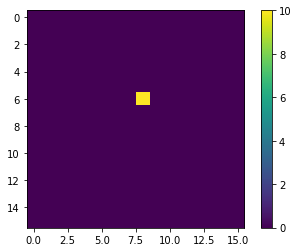

Running Q-Learning Agent...
Done


In [7]:
print('Reward Function in Environment:')
plot_reward_map(gw_obst)

number_of_episodes = 5000
## run the Q learning agent through the environment 
modelfree  = Q_Agent(gw_obst.nstates, gw_obst.nactions)
print('Running Q-Learning Agent...')
q_rewards,q_snapshot = modelfree.navigate(gw_obst, num_episodes=number_of_episodes)
print('Done')

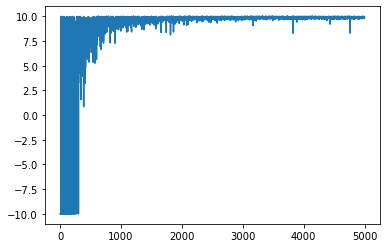

In [8]:
plt.plot(q_rewards)
plt.show()

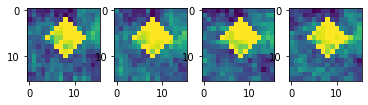

In [9]:
index = 20
fig, ax = plt.subplots(1,gw_obst.nactions)
for i in range(gw_obst.nactions):
    ax[i].imshow(q_snapshot[index][:,i].reshape(n_rows,n_cols))
#ax[i].imshow(snapshot[index])

In [10]:
modelbased=Dyna_Q_Agent(gw_obst.nstates,gw_obst.nactions)
print('Running Q-Learning Agent...')
dyna_q_rewards,dyna_snapshot = modelbased.navigate(gw_obst, num_episodes=number_of_episodes)
print('Done')

Running Q-Learning Agent...
Done


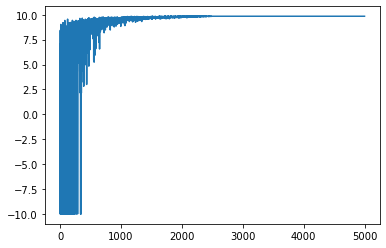

In [11]:
plt.plot(dyna_q_rewards)
plt.show()

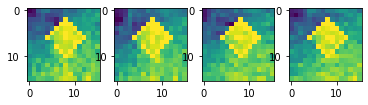

In [12]:
index = 20
fig, ax = plt.subplots(1,gw_obst.nactions)
for i in range(gw_obst.nactions):
    ax[i].imshow(dyna_snapshot[index][:,i].reshape(n_rows,n_cols))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


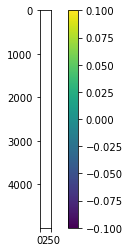

In [14]:
Dyna_q_map = plt.imshow(dyna_snapshot)
plt.colorbar(Dyna_q_map)
plt.show()

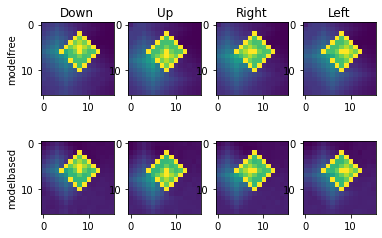

In [16]:
fig, ax = plt.subplots(2,gw_obst.nactions)
for i in range(gw_obst.nactions):
    ax[0,i].imshow(modelfree.q_table[:,i].reshape(n_rows,n_cols))
    ax[1,i].imshow(modelbased.dyna_q_table[:,i].reshape(n_rows,n_cols))
    ax[0,i].set_title(gw_obst.action_list[i])

ax[0,0].set_ylabel('modelfree')#ax[1,0].set_ylabel('Q')
ax[1,0].set_ylabel('modelbased')
plt.show()

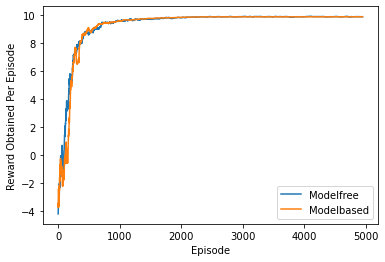

In [17]:
smooth=50
plt.plot(running_mean(q_rewards,smooth), label='Modelfree')
plt.plot(running_mean(dyna_q_rewards,smooth),label='Modelbased')
plt.legend(loc=0)
plt.xlabel('Episode')
plt.ylabel('Reward Obtained Per Episode')
plt.show()